In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import time
import tensorflow

In [2]:

# Helper function
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
    for i in range(num_row * num_col):
        ax = axes[i // num_col, i % num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [3]:

def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)


Training data: (60000, 784) (60000, 10)
Test data: (10000, 784) (10000, 10)


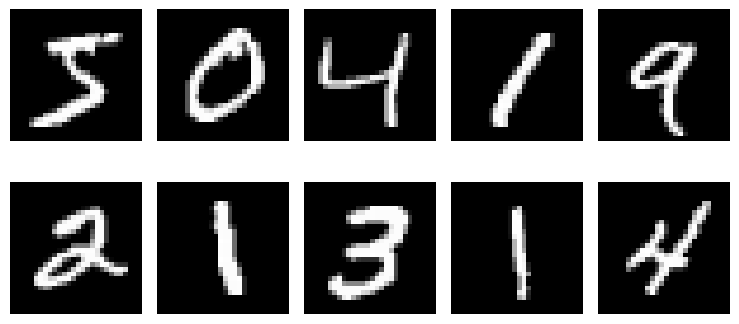

In [4]:
# Loading
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data

x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot encode labels
num_labels = 10
y_train = one_hot(y_train.astype('int32'), num_labels)
y_test = one_hot(y_test.astype('int32'), num_labels)

x_train = x_train.reshape(60000, 28 * 28)
x_test = x_test.reshape(10000, 28 * 28)

print("Training data: {} {}".format(x_train.shape, y_train.shape))
print("Test data: {} {}".format(x_test.shape, y_test.shape))
show_images(x_train)


In [5]:

class DeepNeuralNetwork():
    def __init__(self, sizes, activation='sigmoid', l1_lambda=0.0 , l2_lambda=0.0):
        self.sizes = sizes

        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.train_losses = []  # Train loss history
        self.test_losses = []  # Test loss history
        self.train_accuracies = []  # Train accuracy history
        self.test_accuracies = []  # Test accuracy history
        self.epoch_times = []  # Time taken for each epoch


        # Choose activation function
        if activation == 'relu':
            self.activation = self.relu
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
        else:
            raise ValueError("Activation function is currently not support, please use 'relu' or 'sigmoid' instead.")

        # Save all weights
        self.params = self.initialize()
        # Save all intermediate values, i.e. activations
        self.cache = {}

    def relu(self, x, derivative=False):
        '''
            Derivative of ReLU is a bit more complicated since it is not differentiable at x = 0

            Forward path:
            relu(x) = max(0, x)
            In other word,
            relu(x) = 0, if x < 0
                    = x, if x >= 0

            Backward path:
            ∇relu(x) = 0, if x < 0
                     = 1, if x >=0
        '''
        if derivative:
            x = np.where(x < 0, 0, x)
            x = np.where(x >= 0, 1, x)
            return x
        return np.maximum(0, x)

    def calculate_regularization_penalty(self):
        # L1 Regularization
        l1_penalty = self.lambda_1 * np.sum([np.sum(np.abs(self.params[key])) for key in self.params])
        # L2 Regularization
        l2_penalty = self.lambda_2 * np.sum([np.sum(self.params[key] ** 2) for key in self.params])
        return l1_penalty, l2_penalty

    def sigmoid(self, x, derivative=False):
        '''
            Forward path:
            σ(x) = 1 / 1+exp(-z)

            Backward path:
            ∇σ(x) = exp(-z) / (1+exp(-z))^2
        '''
        if derivative:
            return (np.exp(-x)) / ((np.exp(-x) + 1) ** 2)
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        '''
            softmax(x) = exp(x) / ∑exp(x)
        '''
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0)

    def initialize(self):
        # number of nodes in each layer
        input_layer = self.sizes[0]
        hidden_layer = self.sizes[1]
        output_layer = self.sizes[2]

        params = {
            "W1": np.random.randn(hidden_layer, input_layer) * np.sqrt(1. / input_layer),
            "b1": np.zeros((hidden_layer, 1)) * np.sqrt(1. / input_layer),
            "W2": np.random.randn(output_layer, hidden_layer) * np.sqrt(1. / hidden_layer),
            "b2": np.zeros((output_layer, 1)) * np.sqrt(1. / hidden_layer)
        }
        return params

    def initialize_momemtum_optimizer(self):
        momemtum_opt = {
            "W1": np.zeros(self.params["W1"].shape),
            "b1": np.zeros(self.params["b1"].shape),
            "W2": np.zeros(self.params["W2"].shape),
            "b2": np.zeros(self.params["b2"].shape),
        }
        return momemtum_opt

    def initialize_optimizer(self):
        opt = {
            "W1": np.zeros(self.params["W1"].shape),
            "b1": np.zeros(self.params["b1"].shape),
            "W2": np.zeros(self.params["W2"].shape),
            "b2": np.zeros(self.params["b2"].shape),
        }
        # For Adam-specific parameters
        opt["m"] = {key: np.zeros_like(value) for key, value in self.params.items()}
        opt["v"] = {key: np.zeros_like(value) for key, value in self.params.items()}
        return opt

    def feed_forward(self, x):
        '''
            y = σ(wX + b)
        '''
        self.cache["X"] = x
        self.cache["Z1"] = np.matmul(self.params["W1"], self.cache["X"].T) + self.params["b1"]
        self.cache["A1"] = self.activation(self.cache["Z1"])
        self.cache["Z2"] = np.matmul(self.params["W2"], self.cache["A1"]) + self.params["b2"]
        self.cache["A2"] = self.softmax(self.cache["Z2"])
        return self.cache["A2"]

    def back_propagate(self, y, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is
                  caused  by the dot and multiply operations on the huge arrays.

                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        current_batch_size = y.shape[0]

        dZ2 = output - y.T
        dW2 = (1. / current_batch_size) * np.matmul(dZ2, self.cache["A1"].T)
        db2 = (1. / current_batch_size) * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.matmul(self.params["W2"].T, dZ2)
        dZ1 = dA1 * self.activation(self.cache["Z1"], derivative=True)
        dW1 = (1. / current_batch_size) * np.matmul(dZ1, self.cache["X"])
        db1 = (1. / current_batch_size) * np.sum(dZ1, axis=1, keepdims=True)

        self.grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
        return self.grads

    def cross_entropy_loss(self, y, output, l1_lambda=0, l2_lambda=0):
        '''
            L(y, ŷ) = −∑ylog(ŷ) + λ1*|W| + λ2*W^2.
        '''
        # Cross-Entropy Loss
        l_sum = np.sum(np.multiply(y.T, np.log(output)))
        m = y.shape[0]
        loss = -(1. / m) * l_sum

        # L1 Regularization
        l1_penalty = l1_lambda * sum([np.sum(np.abs(self.params[key])) for key in self.params if 'W' in key])

        # L2 Regularization
        l2_penalty = l2_lambda * sum([np.sum(np.square(self.params[key])) for key in self.params if 'W' in key])

        # Total Loss
        return loss + l1_penalty + l2_penalty


    def optimize(self, l_rate=0.1, beta=0.9, beta2=0.9, epsilon=1e-8, lambda1=0.0, lambda2=0.0):
        '''
            Stochatic Gradient Descent (SGD):
            θ^(t+1) <- θ^t - η∇L(y, ŷ)

            Momentum:
            v^(t+1) <- βv^t + (1-β)∇L(y, ŷ)^t
            θ^(t+1) <- θ^t - ηv^(t+1)
        '''
        if self.optimizer == "sgd":
            for key in self.params:
                # Compute regularization penalties
                l1_penalty = lambda1 * np.sign(self.params[key])
                l2_penalty = lambda2 * self.params[key]

                # Update parameters with penalties
                self.params[key] -= l_rate * (self.grads[key] + l1_penalty + l2_penalty)

        elif self.optimizer == "momentum":
            for key in self.params:
                self.momemtum_opt[key] = beta * self.momemtum_opt[key] + (1. - beta) * self.grads[key]

                # Compute regularization penalties
                l1_penalty = lambda1 * np.sign(self.params[key])
                l2_penalty = lambda2 * self.params[key]

                # Update parameters with penalties
                self.params[key] -= l_rate * (self.momemtum_opt[key] + l1_penalty + l2_penalty)

        elif self.optimizer == "adam":
            t = self.epochs  # Current timestep
            for key in self.params:
                self.optimizer_state["m"][key] = beta * self.optimizer_state["m"][key] + (1 - beta) * self.grads[key]
                self.optimizer_state["v"][key] = beta2 * self.optimizer_state["v"][key] + (1 - beta2) * (
                            self.grads[key] ** 2)

                m_hat = self.optimizer_state["m"][key] / (1 - beta ** t)
                v_hat = self.optimizer_state["v"][key] / (1 - beta2 ** t)

                # Compute regularization penalties
                l1_penalty = lambda1 * np.sign(self.params[key])
                l2_penalty = lambda2 * self.params[key]

                # Update parameters with penalties
                self.params[key] -= l_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + l1_penalty + l2_penalty)

        elif self.optimizer == "rmsprop":
            for key in self.params:
                self.optimizer_state["v"][key] = beta * self.optimizer_state["v"][key] + (1 - beta) * (
                            self.grads[key] ** 2)

                # Compute regularization penalties
                l1_penalty = lambda1 * np.sign(self.params[key])
                l2_penalty = lambda2 * self.params[key]

                # Update parameters with penalties
                self.params[key] -= l_rate * (self.grads[key] / (
                            np.sqrt(self.optimizer_state["v"][key]) + epsilon) + l1_penalty + l2_penalty)

        else:
            raise ValueError("Optimizer is currently not supported, please use 'sgd', 'momentum', 'adam' or 'rmsprop'.")

    def accuracy(self, y, output):
        return np.mean(np.argmax(y, axis=-1) == np.argmax(output.T, axis=-1))

    def train(self, x_train, y_train, x_test, y_test, epochs=10,
              batch_size=64, optimizer='momentum', l_rate=0.1, beta=.9):
        # Hyperparameters
        self.epochs = epochs
        self.batch_size = batch_size
        num_batches = -(-x_train.shape[0] // self.batch_size)

        # Initialize optimizer
        self.optimizer = optimizer
        if self.optimizer == 'momentum':
            self.momemtum_opt = self.initialize_momemtum_optimizer()
        # Initialize optimizer state if using Adam or RMSProp
        elif self.optimizer in ['adam', 'rmsprop']:
            self.optimizer_state = self.initialize_optimizer()

        start_time = time.time()
        template = "Epoch {}: {:.2f}s, train acc={:.2f}, train loss={:.2f}, test acc={:.2f}, test loss={:.2f}"

        # Train
        for i in range(self.epochs):
            epoch_start_time = time.time() ##sonradan ekledim
            # Shuffle
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            for j in range(num_batches):
                # Batch
                begin = j * self.batch_size
                end = min(begin + self.batch_size, x_train.shape[0] - 1)
                x = x_train_shuffled[begin:end]
                y = y_train_shuffled[begin:end]

                # Forward
                output = self.feed_forward(x)
                # Backprop
                grad = self.back_propagate(y, output)
                # Optimize
                self.optimize(l_rate=l_rate, beta=beta)

            # Evaluate performance
            # Training data
            output = self.feed_forward(x_train)
            train_acc = self.accuracy(y_train, output)
            train_loss = self.cross_entropy_loss(y_train, output)
            self.train_accuracies.append(train_acc)
            self.train_losses.append(train_loss)
            # Test data
            output = self.feed_forward(x_test)
            test_acc = self.accuracy(y_test, output)
            test_loss = self.cross_entropy_loss(y_test, output)
            self.test_accuracies.append(test_acc)
            self.test_losses.append(test_loss)

            epoch_time = time.time() - epoch_start_time  # Zaman ölçümü bitişi
            self.epoch_times.append(epoch_time)

            print(template.format(i + 1, time.time() - start_time, train_acc, train_loss, test_acc, test_loss))


In [6]:
def adam_optimizer(self, l_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """ Adam Optimizer """
    if not hasattr(self, 'm'):  # Initialize m and v on first run
        self.m = {key: np.zeros_like(value) for key, value in self.params.items()}
        self.v = {key: np.zeros_like(value) for key, value in self.params.items()}
        self.t = 0  # Time step

    self.t += 1
    for key in self.params:
        # Update biased first moment estimate
        self.m[key] = beta1 * self.m[key] + (1 - beta1) * self.grads[key]
        # Update biased second moment estimate
        self.v[key] = beta2 * self.v[key] + (1 - beta2) * (self.grads[key] ** 2)

        # Compute bias-corrected first moment estimate
        m_hat = self.m[key] / (1 - beta1 ** self.t)
        # Compute bias-corrected second moment estimate
        v_hat = self.v[key] / (1 - beta2 ** self.t)

        # Update parameters
        self.params[key] -= l_rate * m_hat / (np.sqrt(v_hat) + epsilon)



In [7]:
def rmsprop_optimizer(self, l_rate=0.001, beta=0.9, epsilon=1e-8):
    """ RMSProp Optimizer """
    if not hasattr(self, 'cache'):
        self.cache = {key: np.zeros_like(value) for key, value in self.params.items()}

    for key in self.params:
        # Update cache with running average of squared gradients
        self.cache[key] = beta * self.cache[key] + (1 - beta) * (self.grads[key] ** 2)

        # Update parameters
        self.params[key] -= l_rate * self.grads[key] / (np.sqrt(self.cache[key]) + epsilon)


In [8]:
def plot_metrics(dnn): 
    import matplotlib.pyplot as plt

    epochs = range(1, dnn.epochs + 1)

    # Eğitim ve test kayıpları
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, dnn.train_losses, label='Train Loss')
    plt.plot(epochs, dnn.test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Eğitim ve test doğrulukları
    plt.subplot(1, 3, 2)
    plt.plot(epochs, dnn.train_accuracies, label='Train Accuracy')
    plt.plot(epochs, dnn.test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    # Epoch süreleri
    plt.subplot(1, 3, 3)
    plt.plot(epochs, dnn.epoch_times, label='Epoch Time')
    plt.xlabel('Epochs')
    plt.ylabel('ZAMAN (s)')
    plt.title('Time Per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def plot_comparison(dnn1, dnn2, labels):
    import matplotlib.pyplot as plt

    epochs = range(1, max(dnn1.epochs, dnn2.epochs) + 1)

    # Eğitim ve test kayıpları
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, dnn1.train_losses, label=f'{labels[0]} Train Loss')
    plt.plot(epochs, dnn1.test_losses, label=f'{labels[0]} Test Loss')
    plt.plot(epochs, dnn2.train_losses, label=f'{labels[1]} Train Loss')
    plt.plot(epochs, dnn2.test_losses, label=f'{labels[1]} Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Karşılaştırma')
    plt.legend()

    # Eğitim ve test doğrulukları
    plt.subplot(1, 3, 2)
    plt.plot(epochs, dnn1.train_accuracies, label=f'{labels[0]} Train Accuracy')
    plt.plot(epochs, dnn1.test_accuracies, label=f'{labels[0]} Test Accuracy')
    plt.plot(epochs, dnn2.train_accuracies, label=f'{labels[1]} Train Accuracy')
    plt.plot(epochs, dnn2.test_accuracies, label=f'{labels[1]} Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Karşılaştırma')
    plt.legend()

    # Epoch süreleri
    plt.subplot(1, 3, 3)
    plt.plot(epochs, dnn1.epoch_times, label=f'{labels[0]} Epoch Time')
    plt.plot(epochs, dnn2.epoch_times, label=f'{labels[1]} Epoch Time')
    plt.xlabel('Epochs')
    plt.ylabel('ZAMAN (s)')
    plt.title('ZAMAN Karşılaştırma')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1: 0.61s, train acc=0.92, train loss=0.29, test acc=0.92, test loss=0.28
Epoch 2: 1.22s, train acc=0.93, train loss=0.26, test acc=0.93, test loss=0.26
Epoch 3: 1.83s, train acc=0.93, train loss=0.24, test acc=0.93, test loss=0.24
Epoch 4: 2.47s, train acc=0.93, train loss=0.23, test acc=0.93, test loss=0.24
Epoch 5: 3.08s, train acc=0.94, train loss=0.23, test acc=0.93, test loss=0.23
Epoch 6: 3.72s, train acc=0.94, train loss=0.22, test acc=0.93, test loss=0.23
Epoch 7: 4.33s, train acc=0.94, train loss=0.22, test acc=0.93, test loss=0.23
Epoch 8: 4.94s, train acc=0.94, train loss=0.21, test acc=0.93, test loss=0.23
Epoch 9: 5.59s, train acc=0.94, train loss=0.21, test acc=0.93, test loss=0.23
Epoch 10: 6.22s, train acc=0.94, train loss=0.21, test acc=0.93, test loss=0.23


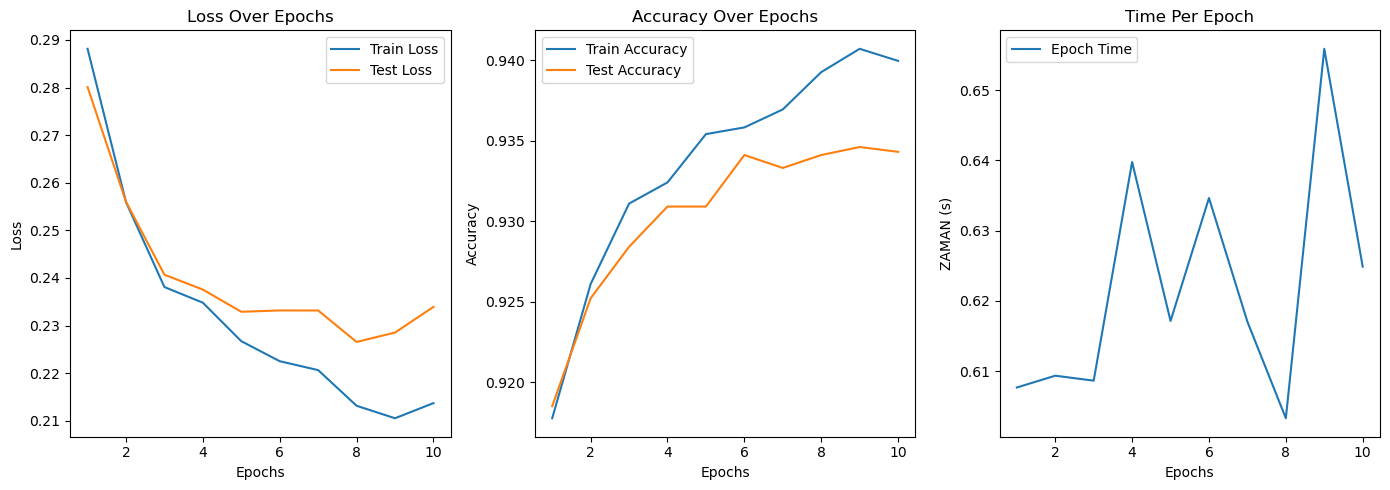

In [10]:
dnn1 = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn1.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='rmsprop', l_rate=0.001)
plot_metrics(dnn1)


Epoch 1: 0.61s, train acc=0.91, train loss=0.34, test acc=0.91, test loss=0.33
Epoch 2: 1.26s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25
Epoch 3: 1.92s, train acc=0.94, train loss=0.21, test acc=0.94, test loss=0.21
Epoch 4: 2.62s, train acc=0.95, train loss=0.18, test acc=0.94, test loss=0.19
Epoch 5: 3.32s, train acc=0.95, train loss=0.16, test acc=0.95, test loss=0.17
Epoch 6: 4.02s, train acc=0.96, train loss=0.14, test acc=0.95, test loss=0.15
Epoch 7: 4.77s, train acc=0.96, train loss=0.13, test acc=0.96, test loss=0.14
Epoch 8: 5.46s, train acc=0.97, train loss=0.12, test acc=0.96, test loss=0.13
Epoch 9: 6.13s, train acc=0.97, train loss=0.11, test acc=0.96, test loss=0.13
Epoch 10: 6.81s, train acc=0.97, train loss=0.10, test acc=0.96, test loss=0.12


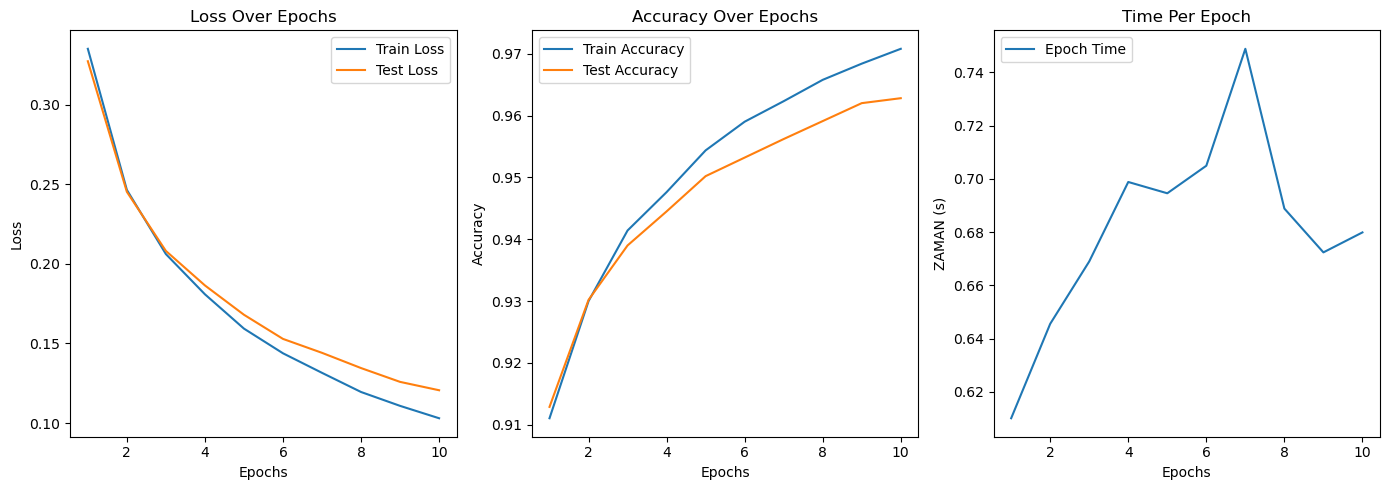

In [11]:
dnn2 = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn2.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='rmsprop', l_rate=0.001)
plot_metrics(dnn2)

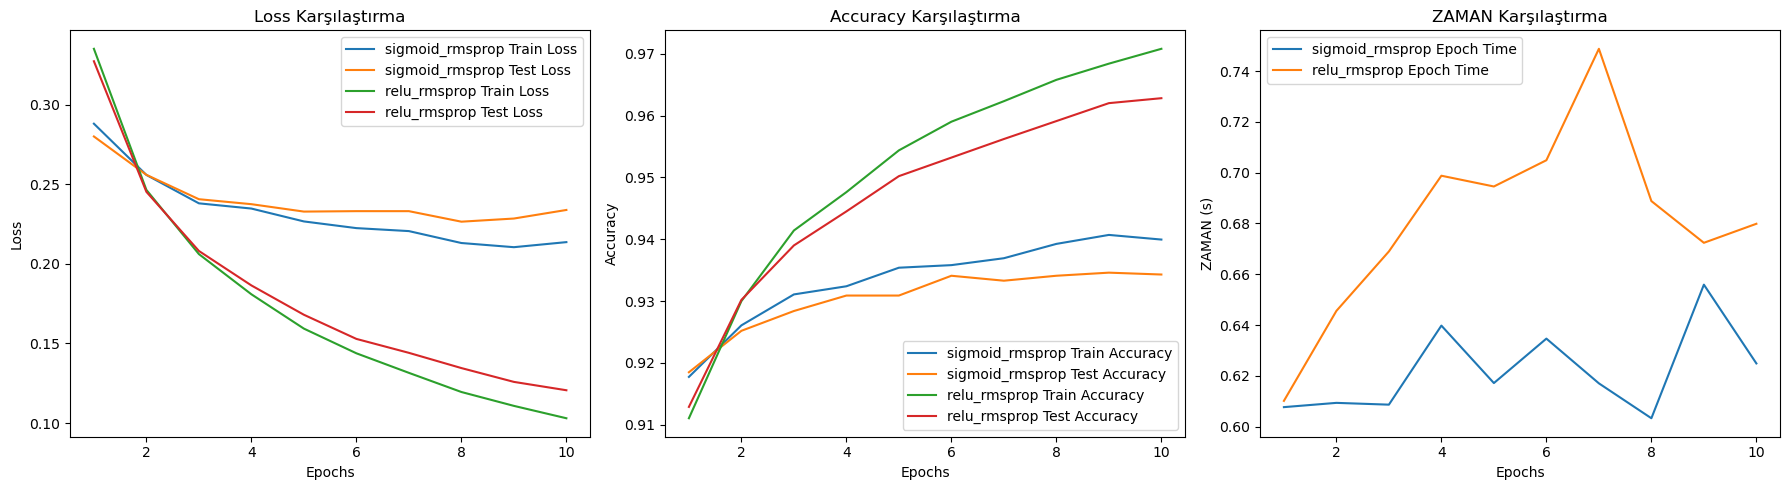

In [12]:
plot_comparison(dnn1,dnn2,["sigmoid_rmsprop","relu_rmsprop"])

Epoch 1: 0.70s, train acc=0.92, train loss=0.30, test acc=0.92, test loss=0.30
Epoch 2: 1.42s, train acc=0.94, train loss=0.22, test acc=0.94, test loss=0.22
Epoch 3: 2.16s, train acc=0.95, train loss=0.18, test acc=0.94, test loss=0.19
Epoch 4: 2.91s, train acc=0.95, train loss=0.16, test acc=0.95, test loss=0.17
Epoch 5: 3.64s, train acc=0.96, train loss=0.14, test acc=0.95, test loss=0.15
Epoch 6: 4.37s, train acc=0.96, train loss=0.12, test acc=0.96, test loss=0.14
Epoch 7: 5.16s, train acc=0.97, train loss=0.11, test acc=0.96, test loss=0.13
Epoch 8: 5.94s, train acc=0.97, train loss=0.10, test acc=0.96, test loss=0.12
Epoch 9: 6.67s, train acc=0.97, train loss=0.09, test acc=0.97, test loss=0.12
Epoch 10: 7.40s, train acc=0.98, train loss=0.08, test acc=0.97, test loss=0.11


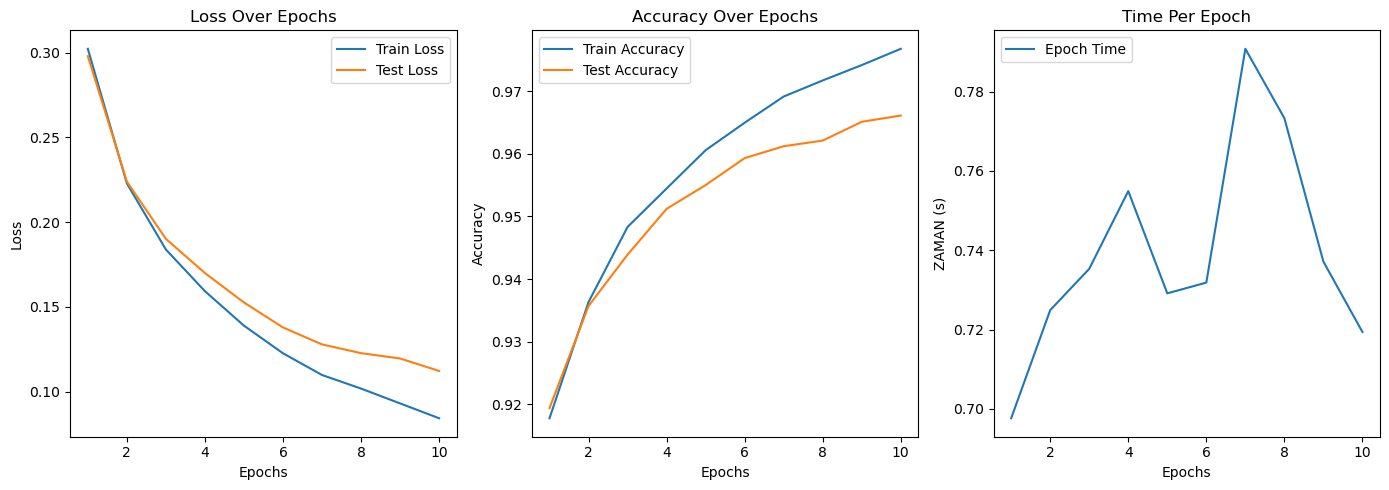

In [13]:
dnn3 = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn3.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='adam', l_rate=0.001)
plot_metrics(dnn3)




Epoch 1: 0.58s, train acc=0.92, train loss=0.28, test acc=0.92, test loss=0.27
Epoch 2: 1.22s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25
Epoch 3: 1.80s, train acc=0.93, train loss=0.23, test acc=0.93, test loss=0.24
Epoch 4: 2.43s, train acc=0.94, train loss=0.23, test acc=0.93, test loss=0.23
Epoch 5: 3.06s, train acc=0.94, train loss=0.22, test acc=0.94, test loss=0.23
Epoch 6: 3.70s, train acc=0.94, train loss=0.22, test acc=0.93, test loss=0.23
Epoch 7: 4.37s, train acc=0.94, train loss=0.21, test acc=0.94, test loss=0.23
Epoch 8: 5.03s, train acc=0.94, train loss=0.22, test acc=0.93, test loss=0.23
Epoch 9: 5.69s, train acc=0.94, train loss=0.21, test acc=0.93, test loss=0.23
Epoch 10: 6.35s, train acc=0.94, train loss=0.21, test acc=0.93, test loss=0.23


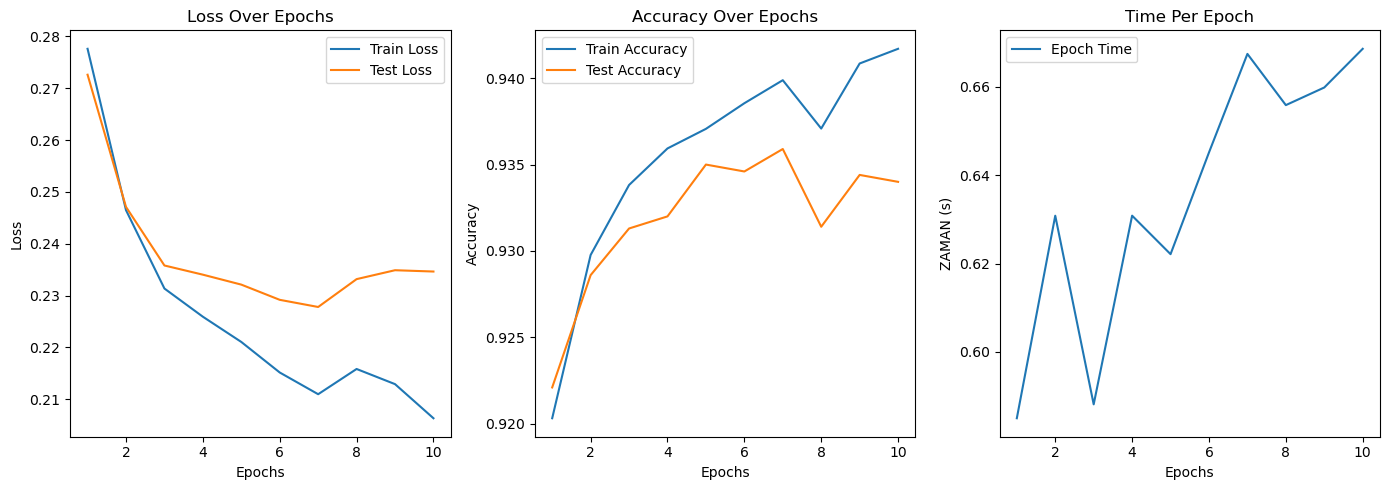

In [14]:
dnn4 = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn4.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='adam', l_rate=0.001)
plot_metrics(dnn4)




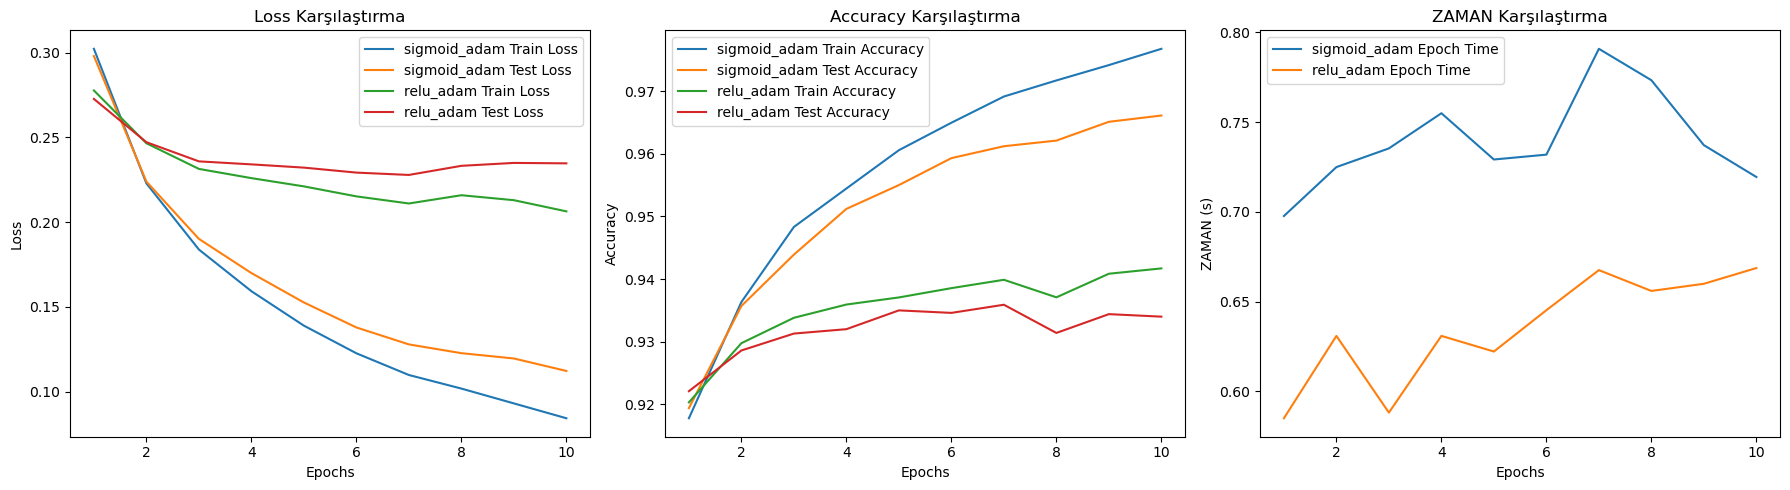

In [15]:
plot_comparison(dnn3,dnn4,["sigmoid_adam","relu_adam"])

Epoch 1: 0.64s, train acc=0.17, train loss=2.28, test acc=0.17, test loss=2.28
Epoch 2: 1.34s, train acc=0.24, train loss=2.24, test acc=0.25, test loss=2.23
Epoch 3: 1.99s, train acc=0.35, train loss=2.20, test acc=0.36, test loss=2.20
Epoch 4: 2.67s, train acc=0.45, train loss=2.17, test acc=0.46, test loss=2.16
Epoch 5: 3.31s, train acc=0.52, train loss=2.13, test acc=0.53, test loss=2.13
Epoch 6: 3.97s, train acc=0.55, train loss=2.10, test acc=0.57, test loss=2.10
Epoch 7: 4.65s, train acc=0.58, train loss=2.07, test acc=0.59, test loss=2.06
Epoch 8: 5.29s, train acc=0.61, train loss=2.03, test acc=0.62, test loss=2.03
Epoch 9: 5.92s, train acc=0.62, train loss=2.00, test acc=0.63, test loss=1.99
Epoch 10: 6.59s, train acc=0.63, train loss=1.97, test acc=0.64, test loss=1.96


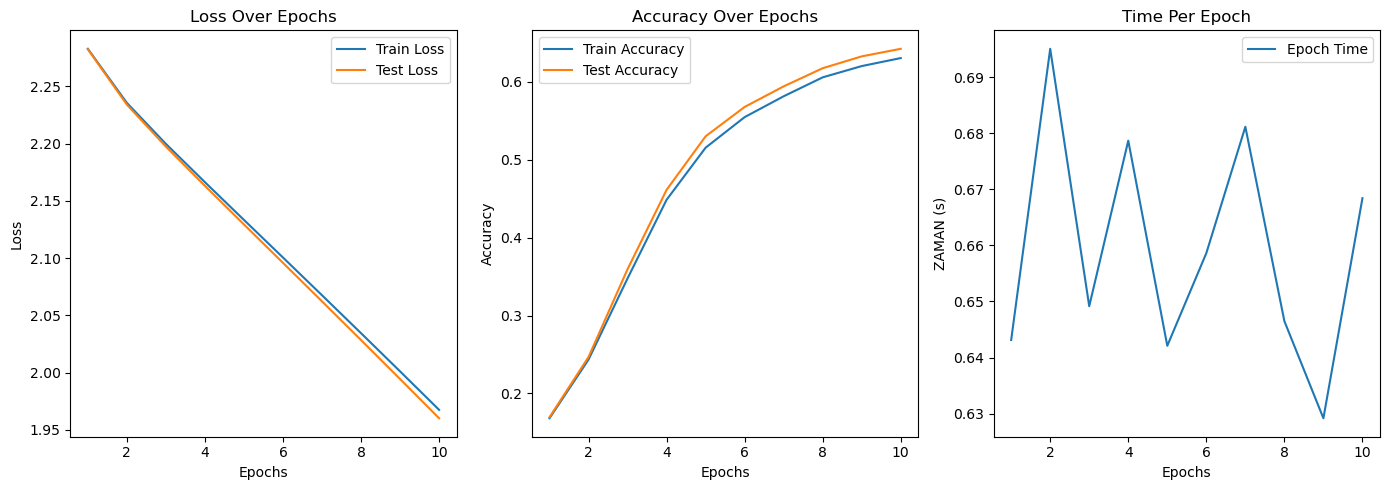

In [16]:
dnn5 = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn5.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='momentum', l_rate=0.001)
plot_metrics(dnn5)

Epoch 1: 0.53s, train acc=0.48, train loss=2.05, test acc=0.48, test loss=2.05
Epoch 2: 1.11s, train acc=0.60, train loss=1.85, test acc=0.61, test loss=1.84
Epoch 3: 1.71s, train acc=0.65, train loss=1.68, test acc=0.67, test loss=1.67
Epoch 4: 2.27s, train acc=0.69, train loss=1.53, test acc=0.71, test loss=1.51
Epoch 5: 2.82s, train acc=0.72, train loss=1.39, test acc=0.74, test loss=1.37
Epoch 6: 3.39s, train acc=0.75, train loss=1.27, test acc=0.76, test loss=1.25
Epoch 7: 3.96s, train acc=0.77, train loss=1.17, test acc=0.78, test loss=1.14
Epoch 8: 4.52s, train acc=0.78, train loss=1.07, test acc=0.79, test loss=1.05
Epoch 9: 5.06s, train acc=0.79, train loss=1.00, test acc=0.81, test loss=0.97
Epoch 10: 5.61s, train acc=0.80, train loss=0.93, test acc=0.82, test loss=0.90


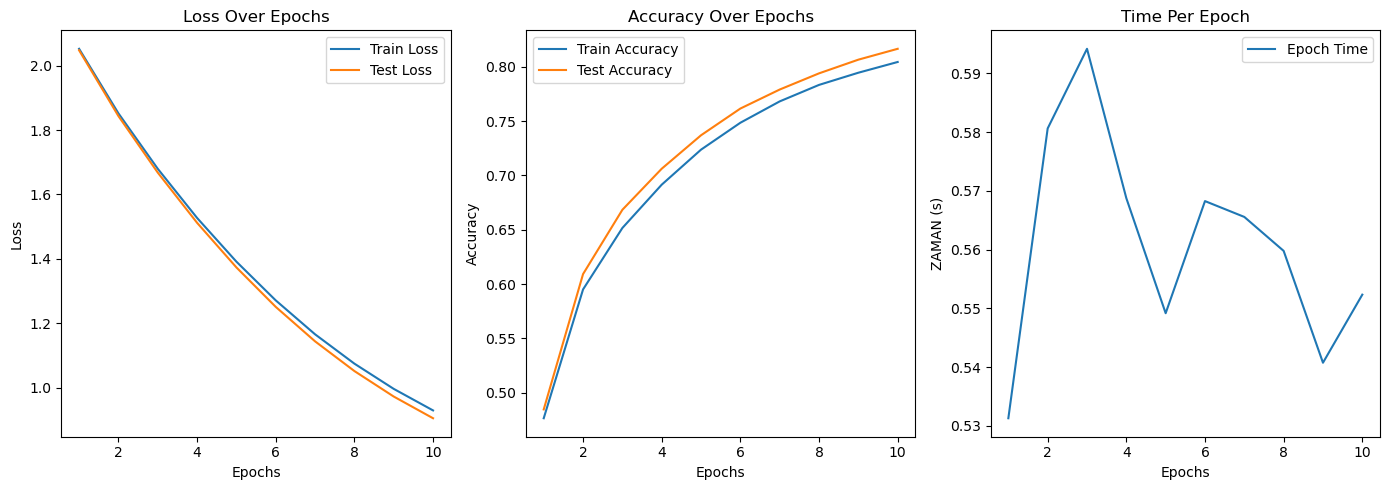

In [17]:
dnn6 = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn6.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='momentum', l_rate=0.001)
plot_metrics(dnn6)

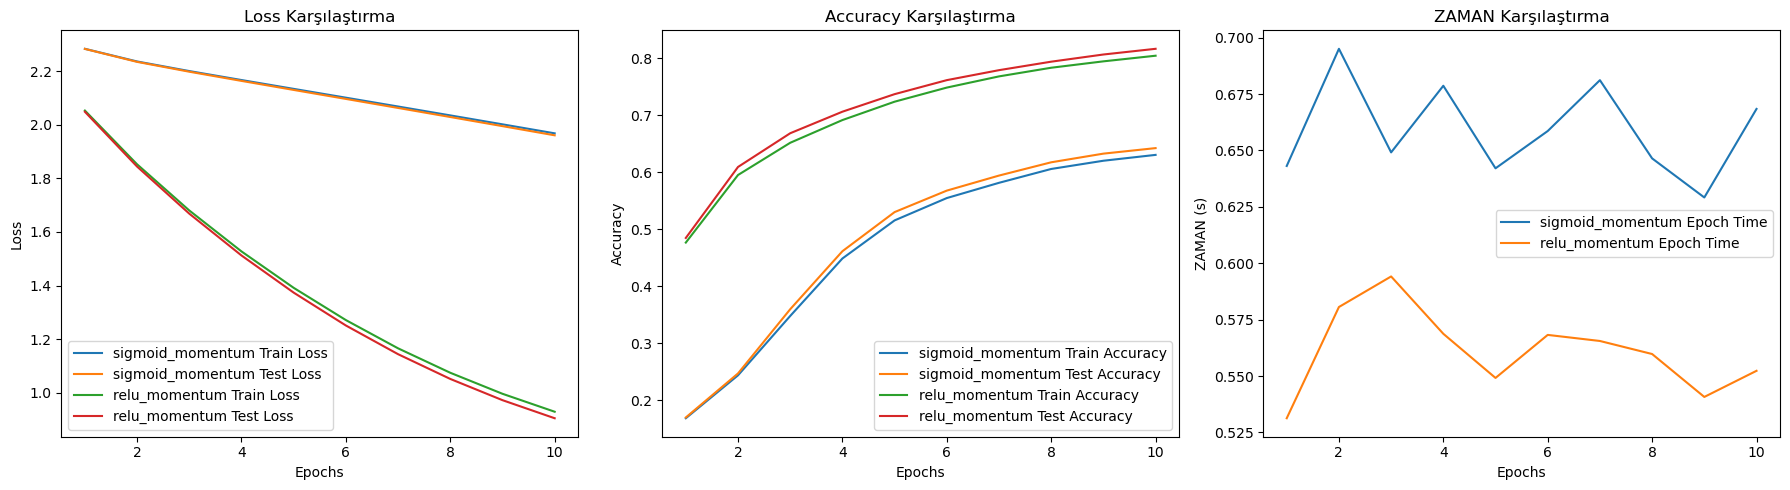

In [18]:
plot_comparison(dnn5,dnn6,["sigmoid_momentum","relu_momentum"])

Epoch 1: 0.63s, train acc=0.16, train loss=2.28, test acc=0.17, test loss=2.28
Epoch 2: 1.28s, train acc=0.24, train loss=2.23, test acc=0.24, test loss=2.23
Epoch 3: 1.95s, train acc=0.41, train loss=2.20, test acc=0.42, test loss=2.20
Epoch 4: 2.57s, train acc=0.49, train loss=2.17, test acc=0.50, test loss=2.16
Epoch 5: 3.21s, train acc=0.54, train loss=2.14, test acc=0.55, test loss=2.13
Epoch 6: 3.85s, train acc=0.57, train loss=2.10, test acc=0.58, test loss=2.10
Epoch 7: 4.49s, train acc=0.60, train loss=2.07, test acc=0.61, test loss=2.07
Epoch 8: 5.12s, train acc=0.61, train loss=2.04, test acc=0.62, test loss=2.03
Epoch 9: 5.76s, train acc=0.63, train loss=2.01, test acc=0.64, test loss=2.00
Epoch 10: 6.40s, train acc=0.64, train loss=1.98, test acc=0.65, test loss=1.97


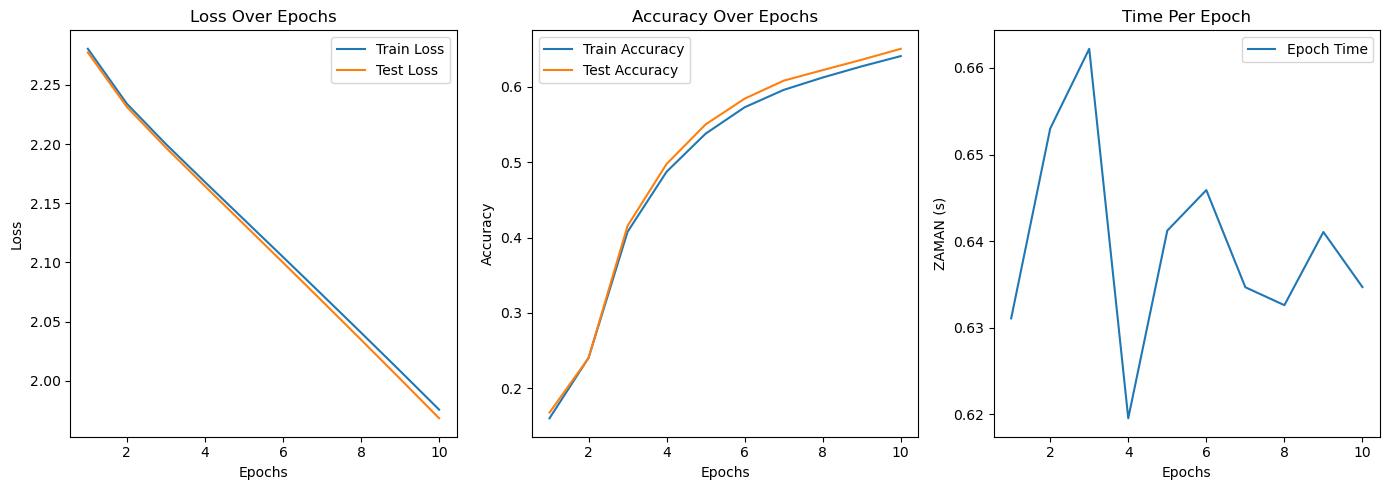

In [19]:
dnn7 = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn7.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='sgd', l_rate=0.001)
plot_metrics(dnn7)

Epoch 1: 0.50s, train acc=0.50, train loss=2.07, test acc=0.50, test loss=2.07
Epoch 2: 1.04s, train acc=0.63, train loss=1.86, test acc=0.63, test loss=1.85
Epoch 3: 1.57s, train acc=0.68, train loss=1.66, test acc=0.67, test loss=1.66
Epoch 4: 2.08s, train acc=0.71, train loss=1.49, test acc=0.70, test loss=1.49
Epoch 5: 2.63s, train acc=0.73, train loss=1.35, test acc=0.73, test loss=1.33
Epoch 6: 3.14s, train acc=0.76, train loss=1.22, test acc=0.76, test loss=1.21
Epoch 7: 3.66s, train acc=0.77, train loss=1.12, test acc=0.78, test loss=1.10
Epoch 8: 4.18s, train acc=0.79, train loss=1.03, test acc=0.79, test loss=1.01
Epoch 9: 4.74s, train acc=0.80, train loss=0.96, test acc=0.80, test loss=0.94
Epoch 10: 5.27s, train acc=0.80, train loss=0.90, test acc=0.81, test loss=0.88


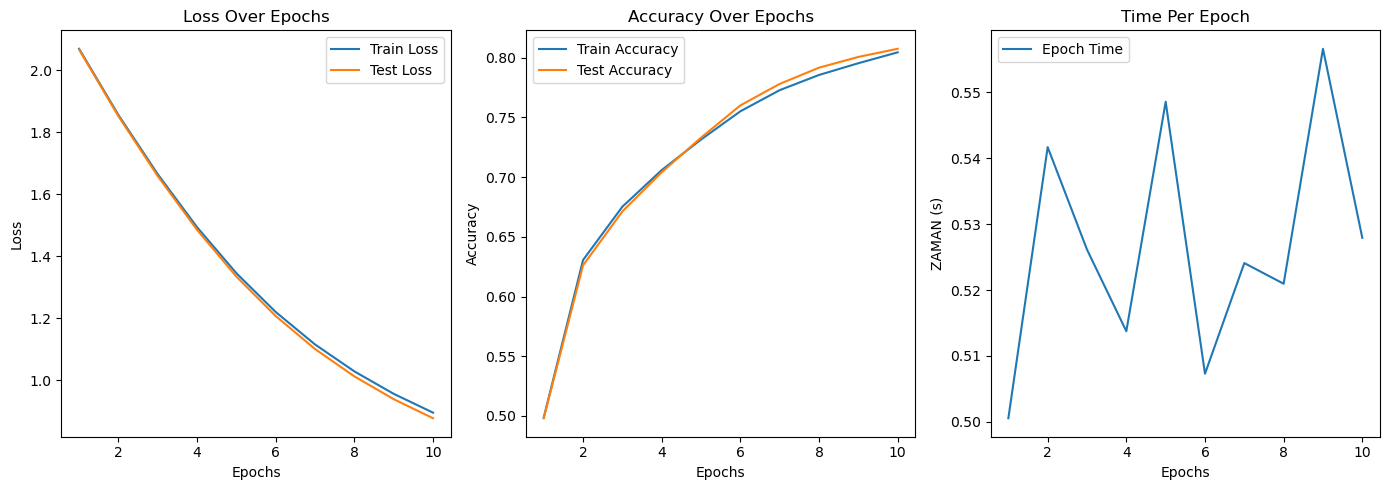

In [20]:
dnn8 = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn8.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='sgd', l_rate=0.001)
plot_metrics(dnn8)

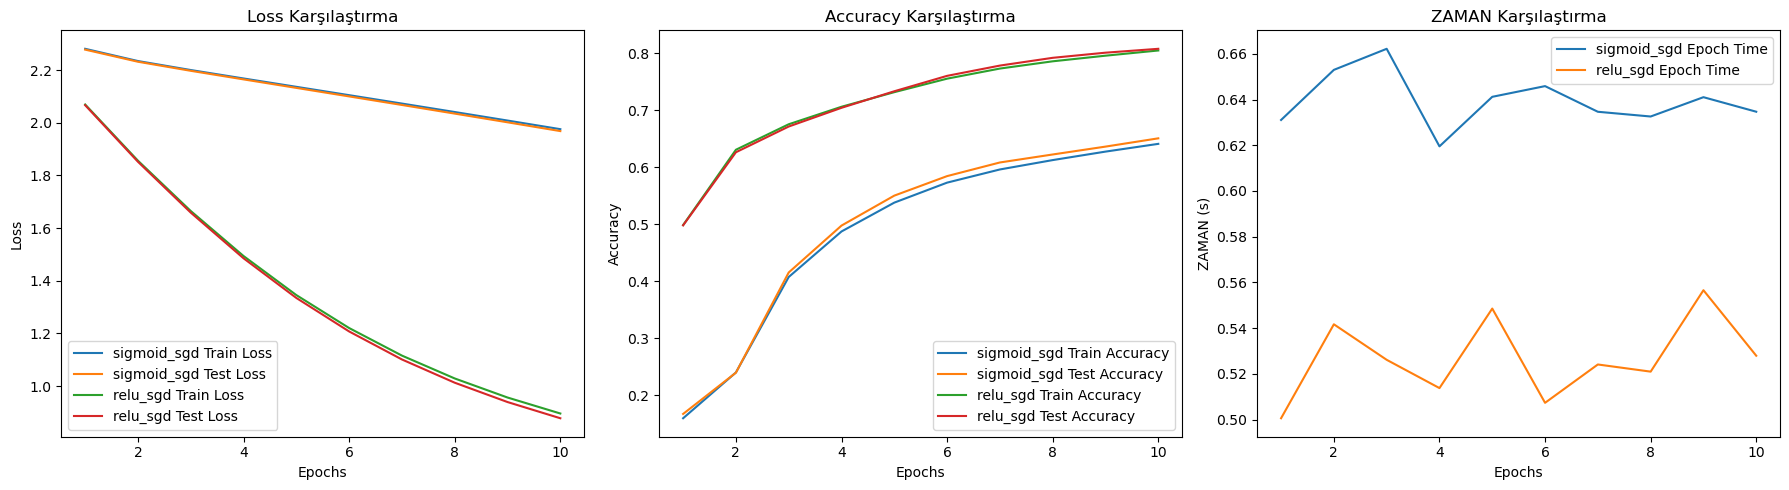

In [21]:
plot_comparison(dnn7,dnn8,["sigmoid_sgd","relu_sgd"])

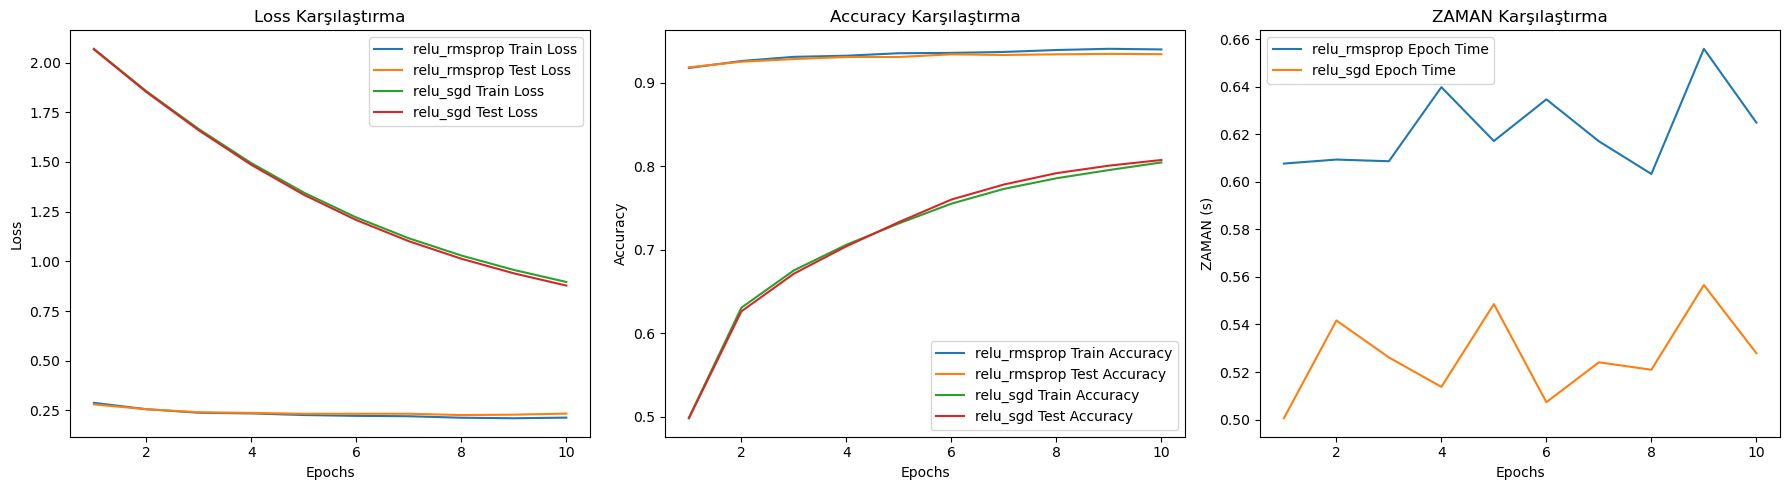

In [22]:
plot_comparison(dnn1,dnn8,["relu_rmsprop","relu_sgd"])

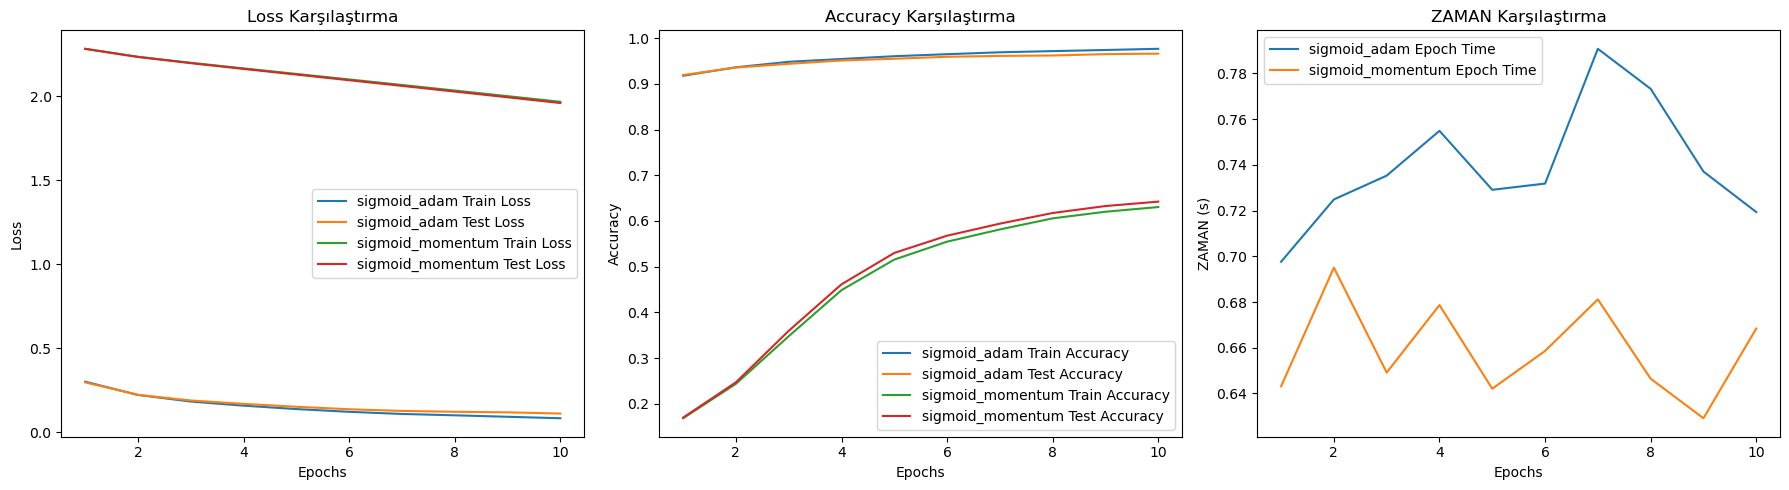

In [23]:
plot_comparison(dnn3,dnn5,["sigmoid_adam","sigmoid_momentum"])

Epoch 1: 0.61s, train acc=0.13, train loss=2.28, test acc=0.13, test loss=2.28
Epoch 2: 1.25s, train acc=0.28, train loss=2.24, test acc=0.28, test loss=2.24
Epoch 3: 1.91s, train acc=0.46, train loss=2.21, test acc=0.46, test loss=2.21
Epoch 4: 2.59s, train acc=0.52, train loss=2.18, test acc=0.51, test loss=2.18
Epoch 5: 3.28s, train acc=0.56, train loss=2.15, test acc=0.55, test loss=2.15
Epoch 6: 3.98s, train acc=0.58, train loss=2.12, test acc=0.58, test loss=2.12
Epoch 7: 4.72s, train acc=0.61, train loss=2.09, test acc=0.61, test loss=2.09
Epoch 8: 5.41s, train acc=0.62, train loss=2.06, test acc=0.62, test loss=2.06
Epoch 9: 6.09s, train acc=0.64, train loss=2.03, test acc=0.64, test loss=2.02
Epoch 10: 6.74s, train acc=0.65, train loss=2.00, test acc=0.65, test loss=1.99


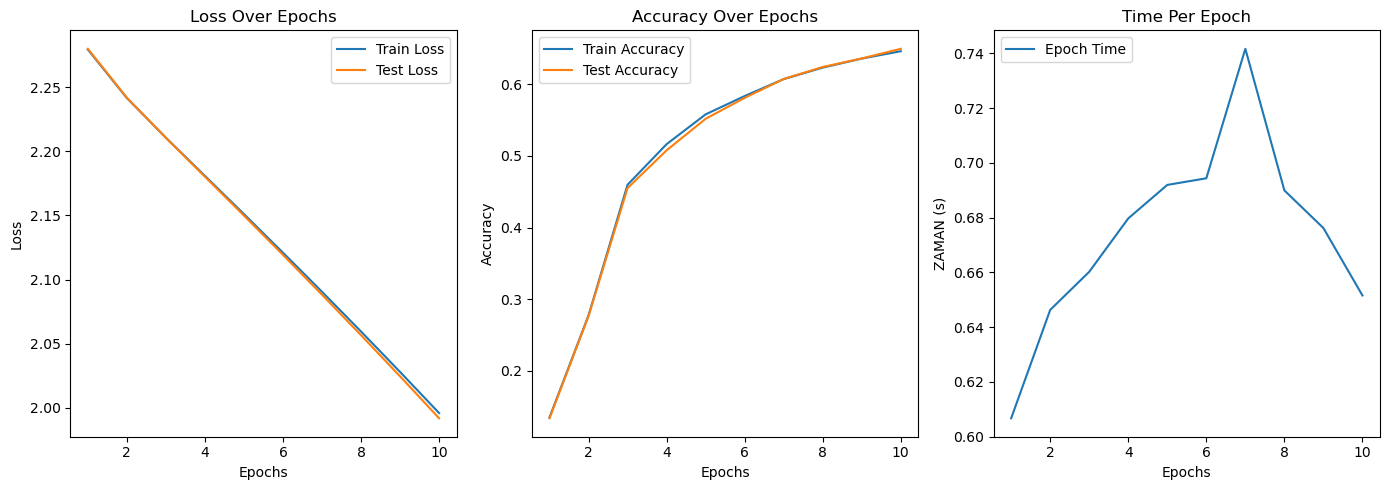

In [24]:
dnn_l1 = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid', l1_lambda=0.5)
dnn_l1.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='momentum', l_rate=0.001)
plot_metrics(dnn_l1)

Epoch 1: 0.73s, train acc=0.14, train loss=2.28, test acc=0.15, test loss=2.28
Epoch 2: 1.45s, train acc=0.30, train loss=2.24, test acc=0.30, test loss=2.23
Epoch 3: 2.20s, train acc=0.47, train loss=2.20, test acc=0.47, test loss=2.20
Epoch 4: 2.91s, train acc=0.52, train loss=2.17, test acc=0.53, test loss=2.17
Epoch 5: 3.69s, train acc=0.56, train loss=2.14, test acc=0.57, test loss=2.14
Epoch 6: 4.40s, train acc=0.59, train loss=2.11, test acc=0.60, test loss=2.11
Epoch 7: 5.10s, train acc=0.62, train loss=2.08, test acc=0.62, test loss=2.07
Epoch 8: 5.78s, train acc=0.64, train loss=2.05, test acc=0.64, test loss=2.04
Epoch 9: 6.47s, train acc=0.65, train loss=2.01, test acc=0.66, test loss=2.01
Epoch 10: 7.15s, train acc=0.66, train loss=1.98, test acc=0.67, test loss=1.97


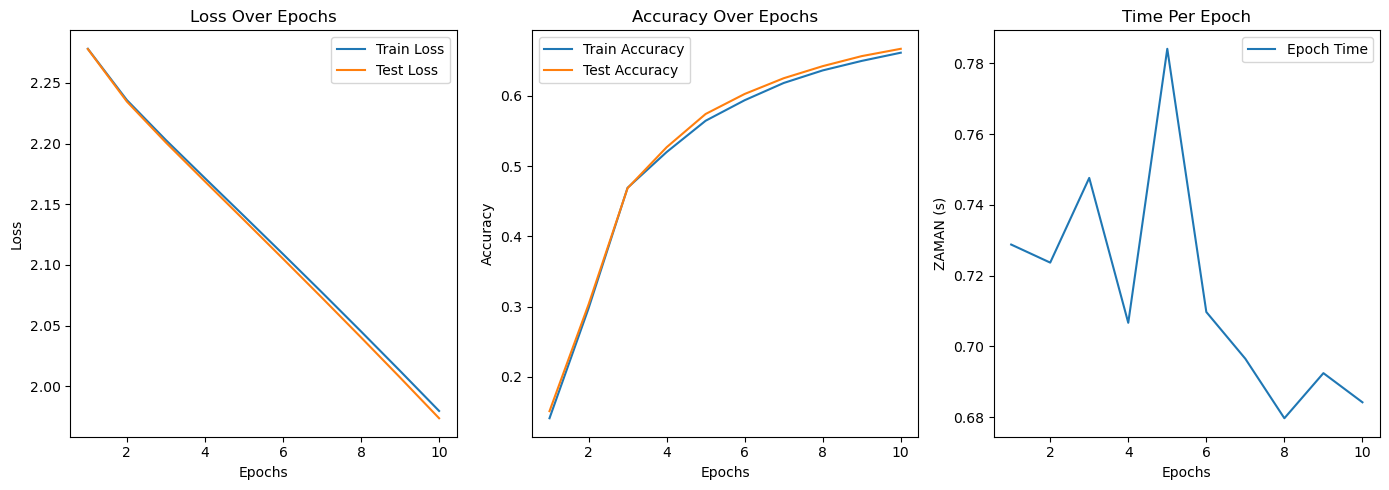

In [28]:
dnn_l2 = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid', l2_lambda=0.5)
dnn_l2.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='momentum', l_rate=0.001)
plot_metrics(dnn_l2)

Epoch 1: 0.66s, train acc=0.20, train loss=2.27, test acc=0.21, test loss=2.27
Epoch 2: 1.34s, train acc=0.28, train loss=2.23, test acc=0.29, test loss=2.23
Epoch 3: 2.01s, train acc=0.40, train loss=2.20, test acc=0.41, test loss=2.19
Epoch 4: 2.66s, train acc=0.48, train loss=2.16, test acc=0.49, test loss=2.16
Epoch 5: 3.33s, train acc=0.52, train loss=2.13, test acc=0.54, test loss=2.12
Epoch 6: 3.99s, train acc=0.56, train loss=2.09, test acc=0.57, test loss=2.09
Epoch 7: 4.66s, train acc=0.58, train loss=2.06, test acc=0.59, test loss=2.05
Epoch 8: 5.37s, train acc=0.60, train loss=2.03, test acc=0.61, test loss=2.02
Epoch 9: 6.03s, train acc=0.62, train loss=1.99, test acc=0.63, test loss=1.98
Epoch 10: 6.68s, train acc=0.63, train loss=1.96, test acc=0.64, test loss=1.95


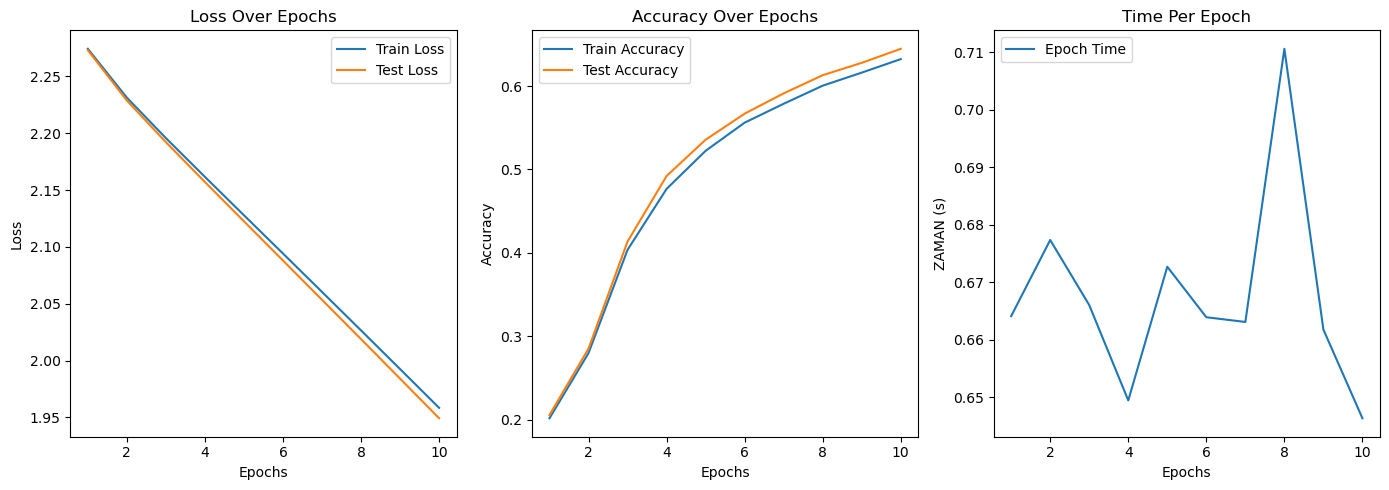

In [30]:
dnn_l2_l1 = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid', l1_lambda=0.7,l2_lambda=0.5)
dnn_l2_l1.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='momentum', l_rate=0.001)
plot_metrics(dnn_l2_l1)

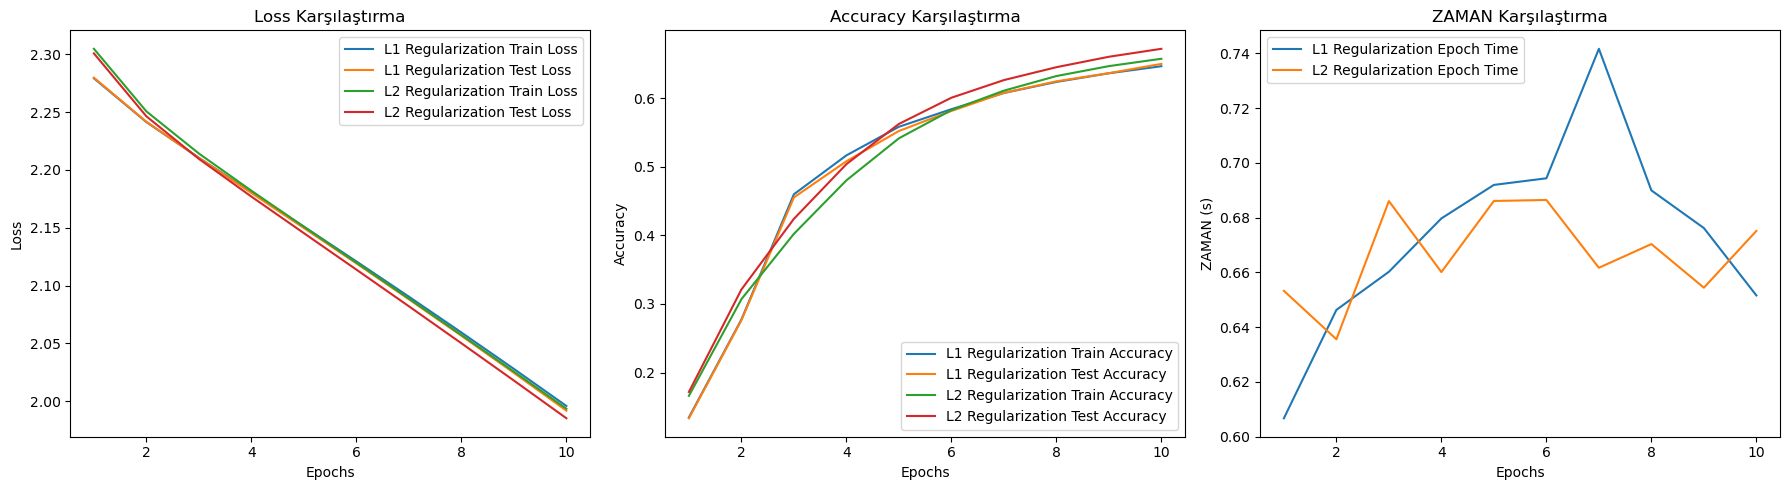

In [26]:
plot_comparison(dnn_l1,dnn_l2,["L1 Regularization","L2 Regularization"])

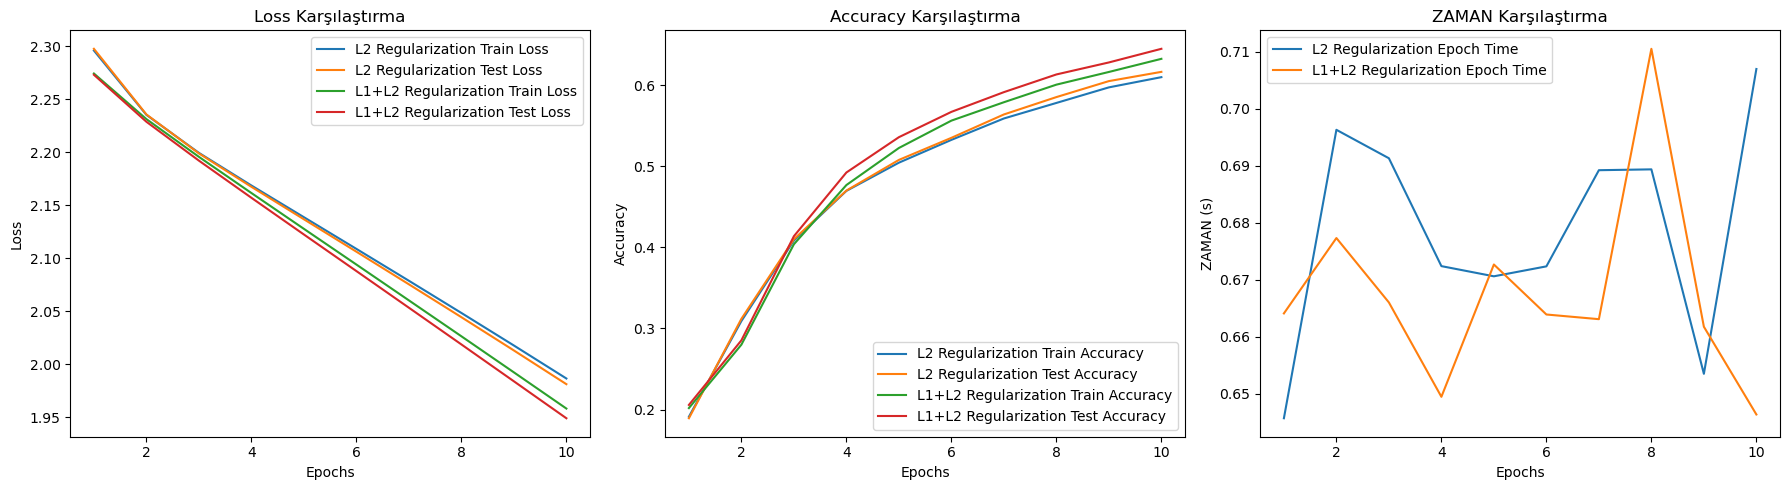

In [31]:
plot_comparison(dnn_l2,dnn_l2_l1,["L2 Regularization","L1+L2 Regularization"])

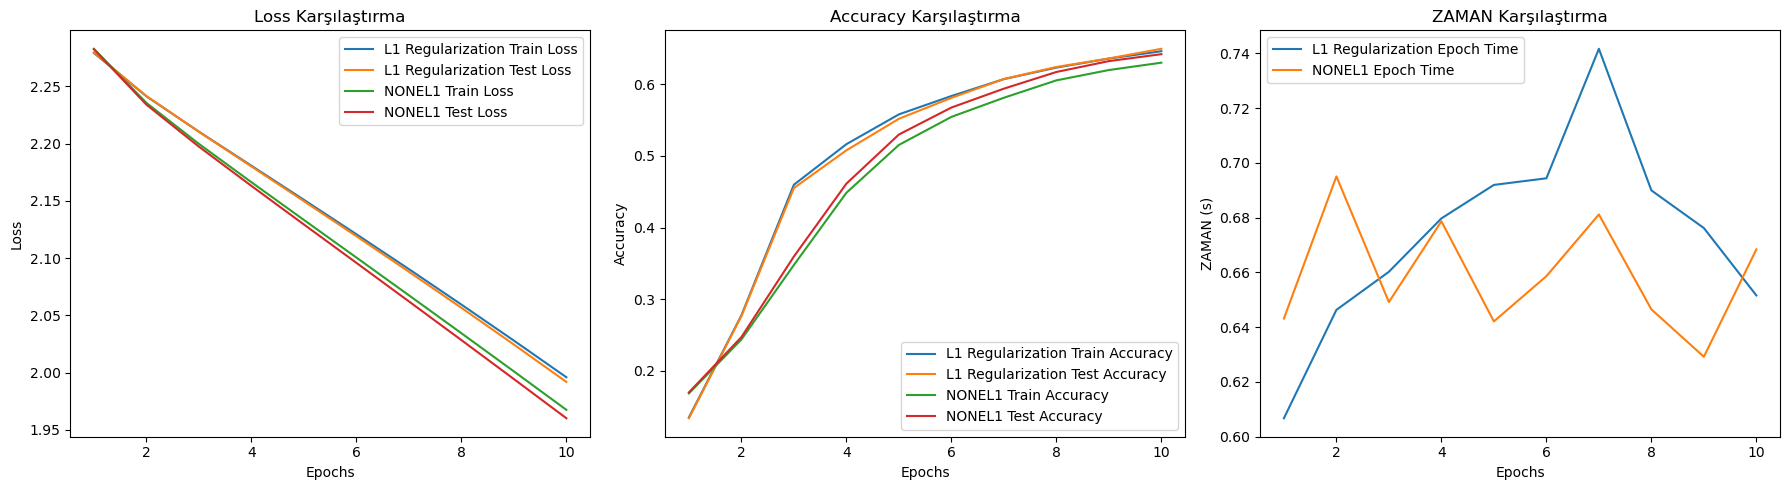

In [32]:
plot_comparison(dnn_l1,dnn5,["L1 Regularization","NONEL1"])